# Model creation and data split-up

This notebook will:
* Split data ito test and train data
* Train the model
* Save the model

Import packages

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pds

Import data

In [4]:
df = pds.read_pickle('ANN_dataset.pkl')
df.head()

,timestamp,lon,lat,direction,speed,journey,seg,time_left,segment_time,tsjs
0,2018-02-16 04:48:40+01:00,58.414238,15.571015,147.300003,0.0,1,1,71.0,71.0,0.0
1,2018-02-16 04:48:41+01:00,58.414246,15.571012,147.300003,0.0,1,1,70.0,71.0,0.0
2,2018-02-16 04:48:42+01:00,58.414249,15.571008,147.300003,0.0,1,1,69.0,71.0,0.0
3,2018-02-16 04:48:43+01:00,58.414257,15.571004,147.300003,0.0,1,1,68.0,71.0,0.0
4,2018-02-16 04:48:44+01:00,58.414257,15.571006,147.300003,0.0,1,1,67.0,71.0,0.0


Note that `segment_time` is the label in this model 

In [19]:
label_string = 'segment_time'

One hot encode segments, normalize columns and create final dataset

In [14]:
# Make segments categorical
dataset = pds.get_dummies(df['seg'])

# Combine segments, timestamps and time from journey start

# Cyclical timestamps 
dataset['hr_sin'] = np.sin(df.timestamp.dt.hour*(2.*np.pi/24))
dataset['hr_cos'] = np.cos(df.timestamp.dt.hour*(2.*np.pi/24))

dataset['tsjs'] = (df['tsjs']-df['tsjs'].min())/(df['tsjs'].max()-df['tsjs'].min())

# Include journey number to select entire journeys
dataset['journey'] = df['journey']
dataset.head()

,1,2,3,4,5,6,7,8,9,10,11,hr_sin,hr_cos,tsjs,journey
0,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.0,1
1,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.0,1
2,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.0,1
3,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.0,1
4,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,0.0,1


Select ~20% test journeys

In [17]:
divider = 0.2
num_journeys = dataset.journey.unique()[-1]
num_test_segments = np.int_(np.round(num_journeys*divider))
msk = np.random.randint(1, num_journeys, num_test_segments)
mask = dataset['journey'].isin(msk)

Divide training and test data, where data is a sequence from a journey

In [21]:
train_input = dataset[~mask]
test_input = dataset[mask]

train_labels = df[label_string][~mask]
test_labels = df[label_string][mask]

In [22]:
# Journey numbers were needed up until this point
train_data = train_input.drop(columns=['journey'])
test_data = test_input.drop(columns=['journey'])

Build model

In [23]:
model = keras.Sequential([
	keras.layers.Dense(len(train_data.columns), activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
    keras.layers.Dense(len(train_data.columns), activation=tf.nn.relu),
	keras.layers.Dense(1, activation=tf.nn.relu)
	])

optimizer = keras.optimizers.Adadelta()
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 15        
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________
None


Fit model, 10% of all training data is used as validation data

In [27]:
EPOCHS=5
model.fit(train_data.values, train_labels.values, epochs = EPOCHS, validation_split=0.1, initial_epoch=0)

Train on 2442094 samples, validate on 271344 samples
Epoch 1/5
2442094/2442094 [==============================] - 56s 23us/step - loss: 17.4884 - mean_absolute_error: 17.4884 - val_loss: 17.5675 - val_mean_absolute_error: 17.5675
Epoch 2/5
2442094/2442094 [==============================] - 55s 23us/step - loss: 17.4834 - mean_absolute_error: 17.4834 - val_loss: 17.5573 - val_mean_absolute_error: 17.5573
Epoch 3/5
2442094/2442094 [==============================] - 56s 23us/step - loss: 17.4809 - mean_absolute_error: 17.4809 - val_loss: 17.5596 - val_mean_absolute_error: 17.5596
Epoch 4/5
2442094/2442094 [==============================] - 56s 23us/step - loss: 17.4777 - mean_absolute_error: 17.4777 - val_loss: 17.5994 - val_mean_absolute_error: 17.5994
Epoch 5/5
2442094/2442094 [==============================] - 60s 25us/step - loss: 17.4742 - mean_absolute_error: 17.4742 - val_loss: 17.4764 - val_mean_absolute_error: 17.4764


Evaluate model on all test data

In [28]:
model.evaluate(test_data.values, test_labels.values)

598562/598562 [==============================] - 5s 9us/step


[16.859156629768925, 16.859156629768925]

Prepare data for the evaluation step

In [46]:
# Same name for all files
model_name = 'ANN_M1'

# Serialize model to YAML
model_yaml = model.to_yaml()
with open(model_name + '.yaml', "w") as yaml_file:
    yaml_file.write(model_yaml)

# Serialize weights to HDF5
model.save_weights(model_name + '.h5')

In [43]:
output = pds.concat([test_input, test_labels], axis=1)
output.head()

,1,2,3,4,5,6,7,8,9,10,11,hr_sin,hr_cos,tsjs,journey,segment_time
641,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2,191.0
642,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2,191.0
643,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2,191.0
644,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2,191.0
645,1,0,0,0,0,0,0,0,0,0,0,0.965926,0.258819,0.0,2,191.0


In [47]:
output.to_pickle(model_name + '.pkl')

Done! Get ready for evaluation

An arbitrary number from `msk` is chosen, i.e. a journey, to a comparison with original data.

In [27]:
selected_journey = np.random.choice(msk)
to_test = test_input[test_input['journey_number'] == selected_journey]
model_to_predict = to_test.drop(columns=['journey_number'])
predictions = model.predict(model_to_predict.values, batch_size=1, verbose=1)

911/911 [==============================] - 0s 137us/step


In [28]:
journey_ = test_input.index[test_input['journey_number'] == selected_journey]
j_labels = test_labels.loc[journey_]
j_labels = j_labels.reset_index().drop(columns=['index'])

Green line is the predicted time, red is the actual time.
Note that the predicted time is the time it takes to drive an entire segment.

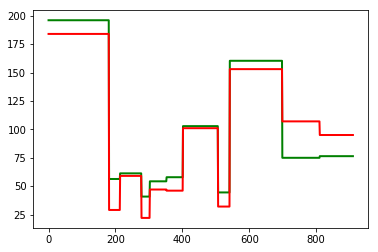

In [29]:
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(j_labels, color='red', linewidth=2, markersize=12)
plt.show()

Note that the plot above contains all 11 segments. According to the plot, and as expected, the network produces the same predicted value for each entry from each segment.

Below is a final scatterplot from the entire test data set.

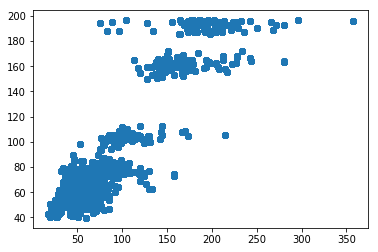

In [14]:
test_predictions = model.predict(test_data.values)
plt.scatter(test_labels.values, test_predictions)
plt.show()